In [ ]:
!nvidia-smi

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!nvcc --version

import locale
import torch
import os

locale.getpreferredencoding = lambda: "UTF-8"
BASE_PATH = os.path.dirname(os.getcwd())

VISIBLE_GPUS = [0]


os.environ["CUDA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
os.environ["NVIDIA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
print("CUDA GPUS NUMBER: ", torch.cuda.device_count())


In [ ]:
import os
from IPython import get_ipython
INSTALL_LIBS = False

if INSTALL_LIBS:
    try:
        import detectron2
        print("Detectron2 already installed")
        os.chdir(BASE_PATH)
    except ModuleNotFoundError:
        !pip install 'git+https://github.com/facebookresearch/detectron2.git'
        print("REINICIANDO SESSÃO!!\nRE-EXECUTE A PARTIR DA PRIMEIRA CELULA PARA CARREGAR O MODULO DETECTRON2 PARA O MASK2FORMER")
        if get_ipython():
            get_ipython().kernel.do_shutdown(restart=True)

In [5]:
import torch
torch.cuda.empty_cache()
print(f'Device Name: {torch.cuda.get_device_name()}')
print(f'Device Available: {torch.cuda.is_available()}')
print(f'Device Count: {torch.cuda.device_count()}')

TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

Device Name: NVIDIA H100 80GB HBM3
Device Available: True
Device Count: 1
torch:  2.5 ; cuda:  cu124


In [ ]:
import os
import subprocess
import sys
import warnings
warnings.filterwarnings('ignore')
MASK2FORMER_PATH = "/Mask2Former"
PIXEL_DECODER_OPS_PATH = os.path.join(MASK2FORMER_PATH, "mask2former/modeling/pixel_decoder/ops")

sys.path.append(MASK2FORMER_PATH)

def install_mask2former():
    if not os.path.exists(MASK2FORMER_PATH):
        print("Cloning Mask2Former...")
        subprocess.run(["git", "clone", "https://github.com/facebookresearch/Mask2Former.git", MASK2FORMER_PATH], check=True)
    else:
        print("Mask2Former repo already exists.")
    
    os.chdir(MASK2FORMER_PATH)
    
    print("Instaling Mask2Former...")
    subprocess.run(["pip", "install", "git+https://github.com/cocodataset/panopticapi.git"], check=True)
    subprocess.run(["pip", "install", "-r", "requirements.txt"], check=True)
    
    os.chdir(PIXEL_DECODER_OPS_PATH)
    
    print("compiling Mask2Former...")
    subprocess.run(["python", "setup.py", "build", "install"], check=True)
    
    os.chdir(BASE_PATH)
    print("Instalation: done!")

def check_mask2former():
    try:
        os.chdir(MASK2FORMER_PATH)
        import mask2former
        print("Mask2Former installed and imported.")
    except (FileNotFoundError, ModuleNotFoundError):
        print("Mask2Former path not found. Instaling...")
        install_mask2former()
        os.kill(os.getpid(), 9)
    finally:
        os.chdir(BASE_PATH)

check_mask2former()

Mask2Former installed and imported.


In [ ]:
TRAIN_DATASET_IMG = "/dataset/train/images"
TEST_DATASET_IMG = "/dataset/test/images"
VAL_DATASET_IMG = "/dataset/val/images"

TRAIN_DATASET_JSON = "/dataset/coco_format/train_unified.json"
TEST_DATASET_JSON = "/dataset/coco_format/test_unified.json"
VAL_DATASET_JSON = "/dataset/coco_format/val_unified.json"

train_dataset_name = 'unified_train'
test_dataset_name = 'unified_test'
val_dataset_name = 'unified_val'

DatasetCatalog.clear()
MetadataCatalog.clear()
register_coco_instances(train_dataset_name, {}, TRAIN_DATASET_JSON, TRAIN_DATASET_IMG)
register_coco_instances(test_dataset_name, {}, TEST_DATASET_JSON, TEST_DATASET_IMG)
register_coco_instances(val_dataset_name, {}, VAL_DATASET_JSON, VAL_DATASET_IMG)

In [ ]:
import pandas as pd
import json
from IPython.display import display, HTML

def load_json(json_file_path):
    try:
        with open(json_file_path, 'r') as f:
            return json.load(f)
    except Exception as e:
        print(f"Error loading {json_file_path}: {e}")
        return None

def datasets_to_table_simplified_with_totals(json_paths):
    summary_data = {}
    total_annotations = {"Train": 0, "Validation": 0, "Test": 0}
    total_images = {"Train": 0, "Validation": 0, "Test": 0}

    for dataset_type, json_path in json_paths.items():
        data = load_json(json_path)
        if not data:
            continue

        if not all(key in data for key in ['images', 'annotations', 'categories']):
            print(f"Chaves necessárias não encontradas no JSON {json_path}.")
            continue

        for category in data['categories']:
            category_name = category.get('name', 'N/A')

            category_annotations = [
                ann for ann in data['annotations'] if ann.get('category_id') == category.get('id', 'N/A')
            ]
            num_annotations = len(category_annotations)

            image_ids = {ann['image_id'] for ann in category_annotations}
            num_images = len(image_ids)

            total_annotations[dataset_type] += num_annotations
            total_images[dataset_type] += num_images

            if category_name not in summary_data:
                summary_data[category_name] = {"Train": [0, 0], "Validation": [0, 0], "Test": [0, 0]}
            summary_data[category_name][dataset_type] = [num_annotations, num_images]

    grand_total_annotations = sum(total_annotations.values())
    grand_total_images = sum(total_images.values())

    sorted_data = sorted(summary_data.items(), key=lambda x: x[0])

    table_rows = []
    for idx, (category_name, stats) in enumerate(sorted_data):
        row = {
            "Category Name": category_name,
            "Train Annotations": stats['Train'][0],
            "Train Annotations %": f"{stats['Train'][0] / total_annotations['Train'] * 100:.1f}%" if total_annotations['Train'] else 0,
            "Train Images": stats['Train'][1],
            "Train Images %": f"{stats['Train'][1] / total_images['Train'] * 100:.1f}%" if total_images['Train'] else 0,
            "Validation Annotations": stats['Validation'][0],
            "Validation Annotations %": f"{stats['Validation'][0] / total_annotations['Validation'] * 100:.1f}%" if total_annotations['Validation'] else 0,
            "Validation Images": stats['Validation'][1],
            "Validation Images %": f"{stats['Validation'][1] / total_images['Validation'] * 100:.1f}%" if total_images['Validation'] else 0,
            "Test Annotations": stats['Test'][0],
            "Test Annotations %": f"{stats['Test'][0] / total_annotations['Test'] * 100:.1f}%" if total_annotations['Test'] else 0,
            "Test Images": stats['Test'][1],
            "Test Images %": f"{stats['Test'][1] / total_images['Test'] * 100:.1f}%" if total_images['Test'] else 0,
        }
        table_rows.append(row)

    table_rows.append({
        "Category Name": "Total Parcial",
        "Train Annotations": total_annotations['Train'],
        "Train Annotations %": f"{total_annotations['Train'] / grand_total_annotations * 100:.1f}%" if grand_total_annotations else 0,
        "Train Images": total_images['Train'],
        "Train Images %": f"{total_images['Train'] / grand_total_images * 100:.1f}%" if grand_total_images else 0,
        "Validation Annotations": total_annotations['Validation'],
        "Validation Annotations %": f"{total_annotations['Validation'] / grand_total_annotations * 100:.1f}%" if grand_total_annotations else 0,
        "Validation Images": total_images['Validation'],
        "Validation Images %": f"{total_images['Validation'] / grand_total_images * 100:.1f}%" if grand_total_images else 0,
        "Test Annotations": total_annotations['Test'],
        "Test Annotations %": f"{total_annotations['Test'] / grand_total_annotations * 100:.1f}%" if grand_total_annotations else 0,
        "Test Images": total_images['Test'],
        "Test Images %": f"{total_images['Test'] / grand_total_images * 100:.1f}%" if grand_total_images else 0,
    })

    table_rows.append({
        "Category Name": "Total Geral (tre/tst/val)",
        "Train Annotations": grand_total_annotations,
        "Train Annotations %": f"{100}%",
        "Train Images": grand_total_images,
        "Train Images %": f"{100}%",
        "Validation Annotations": grand_total_annotations,
        "Validation Annotations %": f"{100}%",
        "Validation Images": grand_total_images,
        "Validation Images %": f"{100}%",
        "Test Annotations": grand_total_annotations,
        "Test Annotations %": f"{100}%",
        "Test Images": grand_total_images,
        "Test Images %": f"{100}%",
    })

    df = pd.DataFrame(table_rows)

    html_table = df.to_html(index=False, table_id="DatasetSummaryTable", classes="display")

    datatables_script = """
        <link rel="stylesheet" href="https://cdn.datatables.net/1.13.4/css/jquery.dataTables.min.css">
        <script src="https://code.jquery.com/jquery-3.6.0.min.js"></script>
        <script src="https://cdn.datatables.net/1.13.4/js/jquery.dataTables.min.js"></script>
        <script>
            $(document).ready(function() {
                $('#DatasetSummaryTable').DataTable({
                    "paging": true,
                    "searching": true,
                    "ordering": true,
                    "info": true,
                    "autoWidth": false,
                });
            });
        </script>
        <style>
            table.dataTable thead th {
                background-color: #008080;
                color: white;
            }
            table.dataTable tbody tr:nth-child(even) {
                background-color: #326f42;
            }
            table.dataTable tbody tr:hover {
                background-color: #ddd;
            }
        </style>
    """

    styled_html = f"""
    <div style="overflow-x: auto; width:100%">
        {html_table}
    </div>
    {datatables_script}
    """

    display(HTML(styled_html))

In [ ]:
json_paths = {
    "Train":TRAIN_DATASET_JSON,
    "Validation":VAL_DATASET_JSON,
    "Test":TEST_DATASET_JSON,
}
datasets_to_table_simplified_with_totals(json_paths)

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Rectangle
from PIL import Image


def check_imgs_exists(images_path, json_file_path):
    data = load_json(json_file_path)
    images = data['images']
    
    existing_images = []
    missing_images = []
    
    for image_info in images:
        file_name = image_info['file_name']
        image_path = os.path.join(images_path, file_name)
        if os.path.exists(image_path):
            existing_images.append(image_info)
        else:
            missing_images.append(file_name)
    
    print(f"Total images: {len(images)}")
    
    if missing_images:
        print("\nMissing images:")
        for missing in missing_images:
            print(f"- {missing}")
    
    return {
        "existing_images": existing_images,
        "missing_images": missing_images
    }


def load_json(json_file_path):
    with open(json_file_path, 'r') as f:
        data = json.load(f)
    return data

def count_categories(data):
    categories = data['categories']
    category_id_to_name = {cat['id']: cat['name'] for cat in categories}
    return category_id_to_name

def attach_color_to_each_category(category_id_to_name):
    np.random.seed(42)
    category_id_to_color = {}
    for cat_id in category_id_to_name:
        color = tuple(np.random.rand(3,))
        category_id_to_color[cat_id] = color
    return category_id_to_color

def plot_bounding_box(ax, bbox, edgecolor, alpha=0.5):
    x, y, width, height = bbox
    rect = Rectangle((x, y), width, height, linewidth=2, edgecolor=edgecolor, facecolor='none', alpha=alpha)
    ax.add_patch(rect)

def plot_mask_overlay(ax, segmentation, facecolor, edgecolor, alpha=0.5):
    for seg in segmentation:
        poly = np.array(seg).reshape((int(len(seg)/2), 2))
        polygon = Polygon(poly, facecolor=facecolor, edgecolor=edgecolor, linewidth=2, alpha=alpha)
        ax.add_patch(polygon)

def plot_image_overlayed(
    images_path,
    json_file_path,
    max_images=5,
    plot_contours=True,
    plot_masks=True,
    figure_size=(20, 20),
    legend_font_size=12,
    alpha=0.5,
    ):
    
    verification_result = check_imgs_exists(images_path, json_file_path)
    existing_images_info = verification_result['existing_images']
    
    if len(existing_images_info) == 0:
        print(f"No image provided in {images_path}.")
        return
    
    data = load_json(json_file_path)
    category_id_to_name = count_categories(data)
    category_id_to_color = attach_color_to_each_category(category_id_to_name)
    
    image_id_to_annotations = {}
    for ann in data['annotations']:
        image_id = ann['image_id']
        if image_id not in image_id_to_annotations:
            image_id_to_annotations[image_id] = []
        image_id_to_annotations[image_id].append(ann)

    count = 0
    for image_info in existing_images_info:
        image_id = image_info['id']
        file_name = image_info['file_name']
        image_path = os.path.join(images_path, file_name)

        img = Image.open(image_path).convert('RGB')
        plt.figure(figsize=figure_size)
        plt.imshow(img)
        ax = plt.gca()
        anns = image_id_to_annotations.get(image_id, [])
        for ann in anns:
            cat_id = ann['category_id']
            color = category_id_to_color.get(cat_id, (1, 0, 0))
            category_name = category_id_to_name.get(cat_id, 'N/A')
            if plot_masks and 'segmentation' in ann and isinstance(ann['segmentation'], list):
                facecolor = (*color, 0.5)
                plot_mask_overlay(ax, ann['segmentation'], facecolor=facecolor, edgecolor=color, alpha=alpha)
            if plot_contours and 'bbox' in ann:
                plot_bounding_box(ax, ann['bbox'], edgecolor=color)
            if 'bbox' in ann:
                bbox = ann['bbox']
                x, y = bbox[0], bbox[1]
                ax.text(x, y - 5, category_name, color='white', fontsize=legend_font_size, backgroundcolor='black')
        plt.axis('off')
        plt.title(f"Image ID: {image_id}", fontsize=legend_font_size + 2)
        plt.show()
        count += 1
        if count >= max_images:
            break


In [ ]:
plot_image_overlayed(
    TEST_DATASET_IMG,
    TEST_DATASET_JSON,
    max_images=1,
    plot_contours=True,
    plot_masks=True,
    figure_size=(20, 20),
    legend_font_size=9,
    alpha=0.2,
)

In [ ]:
import os
import json

OUTDIR = '/path/to/output/directory'  # Change this to your desired output directory
metric_file = os.path.join(OUTDIR, "metrics.json")

metrics = []
with open(metric_file, 'r') as infile:
  for line in infile.readlines():
    metrics.append(json.loads(line))

APmetrics = metrics[-1] if "segm/AP" in metrics[-1].keys() else None
if APmetrics is not None:
  metrics.pop(-1)
  APmetrics.pop('iteration', None)
  keys_to_del = []
  for key in APmetrics.keys():
      if "bbox" in key:
          keys_to_del.append(key)
  for k in keys_to_del:
      APmetrics.pop(k, None)

mt = dict()
for k in metrics[0].keys():
    # _temp = [metrics[i][k] for i in range(len(metrics))]
    _temp = [metrics[i].get(k) for i in range(len(metrics))]
    mt.update({k: _temp})

In [15]:
keys = ["total_loss", "lr", "loss_dice", "loss_mask"]

In [ ]:
BASE_PATH = os.path.dirname(os.getcwd())
RESULTS_PATH = 'path/to/results'
OUTDIR = os.path.join(BASE_PATH, RESULTS_PATH)
METRICS_FILE = os.path.join(OUTDIR, "metrics.json")

print(f'''
    BASE_PATH: {BASE_PATH}
    RESULTS_PATH: {RESULTS_PATH}
    OUTDIR: {OUTDIR}
    METRICS_FILE: {METRICS_FILE}
''')

In [ ]:
import os
import json
import torch
import matplotlib.pyplot as plt
%matplotlib inline


def load_json(file_path):
    with open(file_path, 'r') as f:
        metrics_data = [json.loads(line) for line in f]
    return metrics_data

def process_metrics(metric_file):
    torch.cuda.empty_cache()
    metrics = []
    with open(metric_file, 'r') as infile:
        for line in infile:
            metrics.append(json.loads(line))

    APmetrics = metrics[-1] if "bbox/AP" in metrics[-1].keys() else None
    if APmetrics is not None:
        metrics.pop(-1)
        APmetrics.pop('iteration', None)

    all_keys = set()
    for m in metrics:
        all_keys.update(m.keys())

    mt = dict()
    for k in all_keys:
        _temp = [m.get(k, None) for m in metrics]
        mt[k] = _temp

    return mt, APmetrics

def plot_training_and_validation(mt, keys, validation_prefix="validation_", figsize=(15, 10), rem_background=True):
    if rem_background:
        import matplotlib as mpl
        mpl.rcParams['figure.facecolor'] = 'none'
        mpl.rcParams['axes.facecolor'] = 'none'
    
    ks = mt.keys()
    print(f"Available keys: {ks}")
    
    
    fig = plt.figure(figsize=figsize, dpi=300)
    fig.subplots_adjust(hspace=0.5, wspace=0.4)
    
    num_plots = len(keys)
    rows = 2
    cols = (num_plots // rows) + (1 if num_plots % rows != 0 else 0)
    
    for i, k in enumerate(keys):
        if k in mt and 'iteration' in mt:
            plt.subplot(rows, cols, i + 1)
            
            plt.plot(mt["iteration"], mt[k], label=f"Train: {k}", linewidth=2.0)
            
            val_key = validation_prefix + k
            if val_key in mt:
                plt.plot(mt["iteration"], mt[val_key], label=f"Validation: {k}", linestyle='-', linewidth=2.0)
            
            plt.xlabel("Iterations", fontsize=10)
            plt.title(k, fontsize=10)
            plt.legend()
            plt.grid()
    
    plt.show()


mt, APmetrics = process_metrics(METRICS_FILE)
plot_training_and_validation(mt, keys)

In [18]:
import json
import pandas as pd
from IPython.display import display

def display_final_AP_metrics(file_path: str):
    """
    Reads the metrics file, finds the record with the highest iteration,
    and displays global and per-category AP metrics in pandas DataFrames.
    """
    with open(file_path, 'r') as f:
        records = [json.loads(line) for line in f if line.strip()]
    if not records:
        print("Empty or invalid file!")
        return

    final = max(records, key=lambda x: x.get("iteration", 0))

    global_keys = ["AP", "AP50", "AP75", "APs", "APm", "APl"]

    global_rows = []
    for metric_type in ["bbox", "segm"]:
        row = {
            key: final.get(f"{metric_type}/{key}", float("nan"))
            for key in global_keys
        }
        row["Type"] = metric_type
        global_rows.append(row)
    df_global = pd.DataFrame(global_rows).set_index("Type")
    display(df_global.style.format("{:.3f}", na_rep="nan"))

    for metric_type in ["bbox", "segm"]:
        prefix = f"{metric_type}/AP-"
        cat_metrics = {
            key[len(prefix):]: value
            for key, value in final.items()
            if key.startswith(prefix)
        }
        if cat_metrics:
            df_cat = pd.DataFrame.from_dict(cat_metrics, orient="index", columns=["AP"])
            df_cat.index.name = "Category"
            df_cat = df_cat.sort_index()
            display(df_cat.style.format("{:.3f}", na_rep="nan").set_caption(f"Per-Category AP for {metric_type}"))
        else:
            print(f"No per-category metrics for '{metric_type}'.")



display_final_AP_metrics(METRICS_FILE)

,AP,AP50,AP75,APs,APm,APl
Type,,,,,,
bbox,0.000,0.000,0.000,0.000,0.000,0.000
segm,37.216,50.272,43.326,17.075,39.716,45.519


,AP
Category,
agnor_Cluster,0.000
agnor_Leukocyte_Nucleus,0.000
agnor_Nucleus,0.000
agnor_Nucleus_out_of_focus,0.000
agnor_Overlapped_Nuclei,nan
agnor_Satellite,0.000
agnor_non_viable_nucleus,0.000
feulgen_alterada,0.000
feulgen_intermediaria,0.000


,AP
Category,
agnor_Cluster,17.183
agnor_Leukocyte_Nucleus,39.420
agnor_Nucleus,65.672
agnor_Nucleus_out_of_focus,56.762
agnor_Overlapped_Nuclei,nan
agnor_Satellite,9.466
agnor_non_viable_nucleus,14.653
feulgen_alterada,49.640
feulgen_intermediaria,76.285


In [20]:
try:
    import sys
    from fvcore.common.param_scheduler import CosineParamScheduler, MultiStepParamScheduler, StepWithFixedGammaParamScheduler
    from fvcore.common.checkpoint import Checkpointer
    from urllib.parse import parse_qs, urlparse
    from IPython.display import display, HTML
    from torch.utils.data import Subset
    import matplotlib.pyplot as plt
    import cv2, random, json
    import pandas as pd
    import numpy as np
    import itertools
    import datetime
    import logging
    import torch
    import pytz
    import os
    import detectron2
    import detectron2.utils.comm as comm
    import detectron2.data.transforms as T
    from detectron2.data import DatasetMapper, build_detection_test_loader, build_detection_train_loader, get_detection_dataset_dicts
    from detectron2.solver.lr_scheduler import WarmupCosineLR, WarmupMultiStepLR, LRMultiplier, WarmupParamScheduler
    from detectron2.solver.build import build_lr_scheduler, build_optimizer, get_default_optimizer_params
    from detectron2.engine import launch, DefaultTrainer, DefaultPredictor, default_setup
    from detectron2.data.samplers import InferenceSampler, RandomSubsetTrainingSampler
    from detectron2.checkpoint.detection_checkpoint import DetectionCheckpointer
    from detectron2.data import MetadataCatalog, DatasetCatalog, DatasetFromList
    from detectron2.utils.visualizer import Visualizer, ColorMode, GenericMask
    from detectron2.evaluation import COCOEvaluator, inference_on_dataset
    from detectron2.engine import HookBase, EvalHook, PeriodicWriter
    from detectron2.data.datasets import register_coco_instances
    from detectron2.utils.events import get_event_storage
    from detectron2.utils.logger import setup_logger
    from detectron2.data.common import MapDataset
    from detectron2.modeling import build_model
    from detectron2.config import get_cfg
    from detectron2.config import CfgNode
    from collections import defaultdict
    from detectron2 import model_zoo
    from enum import Enum
    import os
    from detectron2.config import CfgNode
    from detectron2.data import build_detection_test_loader
    from detectron2.engine import DefaultPredictor
    from detectron2.evaluation import COCOEvaluator, inference_on_dataset
    from detectron2.config import get_cfg, CfgNode
    from detectron2.projects.deeplab import add_deeplab_config
    from detectron2.utils.visualizer import Visualizer
    from detectron2.config import get_cfg
    from detectron2.utils.visualizer import Visualizer, ColorMode, GenericMask, random_color
    
    from detectron2.engine import DefaultPredictor
    from detectron2.data import DatasetCatalog, MetadataCatalog
    from detectron2.evaluation import COCOEvaluator
    from detectron2.config import get_cfg
    from detectron2.data import build_detection_test_loader
    
    from detectron2.data import (
        MetadataCatalog,
        DatasetCatalog,
    )
    import torch
    import os
    import cv2
    import random
    import mask2former
    from mask2former import add_maskformer2_config
    import warnings
    import math
    warnings.filterwarnings('ignore')
    warnings.filterwarnings("ignore", category=UserWarning)
    warnings.filterwarnings('ignore', category=FutureWarning)
except Exception as e:
    print(f'Error, Detectron 2 not installed: \n{e}')

### INFERENCING VALIDATION SET

In [ ]:
def add_onecycle_config(cfg_test):
    cfg_test.ONECYCLE = CfgNode()
    cfg_test.ONECYCLE.LIMIT = 0.01
    cfg_test.ONECYCLE.MAX_MOMENTUM = 0.95
    cfg_test.ONECYCLE.MIN_MOMENTUM = 0.85
    cfg_test.ONECYCLE.THREE_PHASE = False


def inference_on_test_set(test_dataset_name, test_dataset_json, test_dataset_img, weights_path, config_file, output_dir, output_folder_name):
    DatasetCatalog.clear()
    MetadataCatalog.clear()

    register_coco_instances(test_dataset_name, {}, test_dataset_json, test_dataset_img)

    cfg_test = get_cfg()
    add_deeplab_config(cfg_test)
    add_maskformer2_config(cfg_test)
    add_onecycle_config(cfg_test)
    cfg_test.merge_from_file(config_file)
    
    cfg_test.MODEL.WEIGHTS = weights_path

    cfg_test.OUTPUT_DIR = output_dir
    os.makedirs(cfg_test.OUTPUT_DIR, exist_ok=True)

    cfg_test.MODEL.MASK_FORMER.TEST.SEMANTIC_ON = False
    cfg_test.MODEL.MASK_FORMER.TEST.INSTANCE_ON = True
    cfg_test.MODEL.MASK_FORMER.TEST.PANOPTIC_ON = False

    cfg_test.DATASETS.TEST = (test_dataset_name,)

    with torch.no_grad():
    
        predictor = DefaultPredictor(cfg_test)
    
        out_folder = os.path.join(cfg_test.OUTPUT_DIR, output_folder_name)
        os.makedirs(out_folder, exist_ok=True)
    
        evaluator = COCOEvaluator(test_dataset_name, output_dir=out_folder)
        test_loader = build_detection_test_loader(cfg_test, test_dataset_name)
    
        results = inference_on_dataset(predictor.model, test_loader, evaluator)
    
    return results

val_results = inference_on_test_set(
    test_dataset_name=val_dataset_name,
    test_dataset_json=VAL_DATASET_JSON,
    test_dataset_img=VAL_DATASET_IMG,
    weights_path=os.path.join(OUTDIR, 'best.pth'),
    config_file=os.path.join(OUTDIR, 'maskformer2_swin_base_IN21k_384_bs16_22_classes.yml'),
    output_dir=OUTDIR,
    output_folder_name = 'val'
)

Loading and preparing results...
DONE (t=0.16s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.

In [ ]:
from tabulate import tabulate
from IPython.display import display, HTML

def evaluation_results_to_table_compact(results):
    categories = set(
        category for metrics in results.values() for category in metrics.keys()
    )
    categories = sorted(categories)

    table_data = []
    for category in categories:
        row = [category]
        for metric_type in results.keys():
            value = results[metric_type].get(category, "N/A")
            
            if isinstance(value, float):
                value = round(value, 4)
            row.append(value)
        table_data.append(row)

    headers = ["Metric"] + list(results.keys())

    display(HTML(f"""
    <div style="overflow-x: auto; width:100%">
        {tabulate(table_data, headers=headers, tablefmt="html")}
    </div>
    """))

print("Validation Results:")
evaluation_results_to_table_compact(val_results)


Validation Results:


Metric,bbox,segm
AP,0,34.8933
AP-agnor_Cluster,0,17.6938
AP-agnor_Leukocyte_Nucleus,0,35.5272
AP-agnor_Nucleus,0,64.3806
AP-agnor_Nucleus_out_of_focus,0,54.5926
AP-agnor_Overlapped_Nuclei,0,0
AP-agnor_Satellite,0,4.9132
AP-agnor_non_viable_nucleus,0,13.7039
AP-feulgen_alterada,0,49.6396
AP-feulgen_intermediaria,0,76.2849


### TESTING SET

In [ ]:
import os
from detectron2.engine import DefaultPredictor
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.evaluation import COCOEvaluator
from detectron2.config import get_cfg
from detectron2.data import build_detection_test_loader


def add_onecycle_config(cfg_test):
    cfg_test.ONECYCLE = CfgNode()
    cfg_test.ONECYCLE.LIMIT = 0.01
    cfg_test.ONECYCLE.MAX_MOMENTUM = 0.95
    cfg_test.ONECYCLE.MIN_MOMENTUM = 0.85
    cfg_test.ONECYCLE.THREE_PHASE = False


def inference_on_test_set(test_dataset_name, test_dataset_json, test_dataset_img, weights_path, config_file, output_dir, output_folder_name):
    DatasetCatalog.clear()
    MetadataCatalog.clear()

    register_coco_instances(test_dataset_name, {}, test_dataset_json, test_dataset_img)

    cfg_test = get_cfg()
    add_deeplab_config(cfg_test)
    add_maskformer2_config(cfg_test)
    add_onecycle_config(cfg_test)
    cfg_test.merge_from_file(config_file)
    
    cfg_test.MODEL.WEIGHTS = weights_path

    cfg_test.OUTPUT_DIR = output_dir
    os.makedirs(cfg_test.OUTPUT_DIR, exist_ok=True)

    cfg_test.MODEL.MASK_FORMER.TEST.SEMANTIC_ON = False
    cfg_test.MODEL.MASK_FORMER.TEST.INSTANCE_ON = True
    cfg_test.MODEL.MASK_FORMER.TEST.PANOPTIC_ON = False

    cfg_test.DATASETS.TEST = (test_dataset_name,)

    with torch.no_grad():
    
        predictor = DefaultPredictor(cfg_test)
    
        out_folder = os.path.join(cfg_test.OUTPUT_DIR, output_folder_name)
        os.makedirs(out_folder, exist_ok=True)
    
        evaluator = COCOEvaluator(test_dataset_name, output_dir=out_folder)
        test_loader = build_detection_test_loader(cfg_test, test_dataset_name)
    
        results = inference_on_dataset(predictor.model, test_loader, evaluator)
    
    return results

test_results = inference_on_test_set(
    test_dataset_name=test_dataset_name,
    test_dataset_json=TEST_DATASET_JSON,
    test_dataset_img=TEST_DATASET_IMG,
    weights_path=os.path.join(OUTDIR, 'best.pth'),
    config_file=os.path.join(OUTDIR, 'maskformer2_swin_base_IN21k_384_bs16_22_classes.yml'),
    output_dir=OUTDIR,
    output_folder_name = 'test_with_compress'
)

Loading and preparing results...
DONE (t=0.12s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.

In [ ]:
from tabulate import tabulate
from IPython.display import display, HTML

def evaluation_results_to_table_compact(results):
    categories = set(
        category for metrics in results.values() for category in metrics.keys()
    )
    categories = sorted(categories)

    table_data = []
    for category in categories:
        row = [category]
        for metric_type in results.keys():
            value = results[metric_type].get(category, "N/A")
            
            if isinstance(value, float):
                value = round(value, 4)
            row.append(value)
        table_data.append(row)

    headers = ["Metric"] + list(results.keys())

    display(HTML(f"""
    <div style="overflow-x: auto; width:100%">
        {tabulate(table_data, headers=headers, tablefmt="html")}
    </div>
    """))

evaluation_results_to_table_compact(test_results)

Metric,bbox,segm
AP,0,37.7451
AP-agnor_Cluster,0,16.9212
AP-agnor_Leukocyte_Nucleus,0,36.4247
AP-agnor_Nucleus,0,66.3887
AP-agnor_Nucleus_out_of_focus,0,56.9968
AP-agnor_Overlapped_Nuclei,nan,nan
AP-agnor_Satellite,0,6.817
AP-agnor_non_viable_nucleus,0,10.0244
AP-feulgen_alterada,0,50.9393
AP-feulgen_intermediaria,0,76.3669


### Inference

In [21]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Rectangle
from PIL import Image


def add_onecycle_config(cfg_test):
    cfg_test.ONECYCLE = CfgNode()
    cfg_test.ONECYCLE.LIMIT = 0.01
    cfg_test.ONECYCLE.MAX_MOMENTUM = 0.95
    cfg_test.ONECYCLE.MIN_MOMENTUM = 0.85
    cfg_test.ONECYCLE.THREE_PHASE = False


def load_json(json_file_path):
    with open(json_file_path, 'r') as f:
        data = json.load(f)
    return data

def count_categories(data):
    categories = data['categories']
    category_id_to_name = {cat['id']: cat['name'] for cat in categories}
    return category_id_to_name

def attach_color_to_each_category(category_id_to_name):
    np.random.seed(42)
    category_id_to_color = {}
    for cat_id in category_id_to_name:
        color = tuple(np.random.rand(3,))
        category_id_to_color[cat_id] = color
    return category_id_to_color

def plot_bounding_box(ax, bbox, edgecolor):
    x, y, width, height = bbox
    rect = Rectangle((x, y), width, height, linewidth=2, edgecolor=edgecolor, facecolor='none')
    ax.add_patch(rect)

def plot_mask_overlay(ax, segmentation, facecolor, edgecolor, alpha=0.5):
    for seg in segmentation:
        poly = np.array(seg).reshape((int(len(seg)/2), 2))
        polygon = Polygon(poly, facecolor=facecolor, edgecolor=edgecolor, linewidth=2, alpha=alpha)
        ax.add_patch(polygon)

def plot_image_overlayed(images_path, json_file_path, max_images=5, plot_contours=True, plot_masks=True, figure_size=(20, 20), legend_font_size=12, alpha=0.5):
    data = load_json(json_file_path)
    images = {img['id']: img for img in data['images']}
    annotations = data['annotations']
    category_id_to_name = count_categories(data)
    category_id_to_color = attach_color_to_each_category(category_id_to_name)
    image_id_to_annotations = {}
    for ann in annotations:
        image_id = ann['image_id']
        if image_id not in image_id_to_annotations:
            image_id_to_annotations[image_id] = []
        image_id_to_annotations[image_id].append(ann)
    count = 0
    for image_id, image_info in images.items():
        file_name = image_info['file_name']
        image_path = os.path.join(images_path, file_name)
        if not os.path.exists(image_path):
            continue
        img = Image.open(image_path).convert('RGB')

        plt.figure(figsize=figure_size)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        
        plt.figure(figsize=figure_size)
        plt.imshow(img)
        ax = plt.gca()
        anns = image_id_to_annotations.get(image_id, [])
        for ann in anns:
            cat_id = ann['category_id']
            color = category_id_to_color.get(cat_id, (1, 0, 0))
            category_name = category_id_to_name.get(cat_id, 'N/A')
            if plot_masks and 'segmentation' in ann and isinstance(ann['segmentation'], list):
                facecolor = (*color, 0.5)  # Convert to RGBA
                plot_mask_overlay(ax, ann['segmentation'], facecolor=facecolor, edgecolor=color, alpha=alpha)
            if plot_contours and 'bbox' in ann:
                plot_bounding_box(ax, ann['bbox'], edgecolor=color)
            if 'bbox' in ann:
                bbox = ann['bbox']
                x, y = bbox[0], bbox[1]
                ax.text(x, y - 5, category_name, color='white', fontsize=legend_font_size, backgroundcolor='black')
        plt.axis('off')
        plt.title(f"Image ID: {image_id}", fontsize=legend_font_size + 2)
        plt.show()
        count += 1
        if count >= max_images:
            break


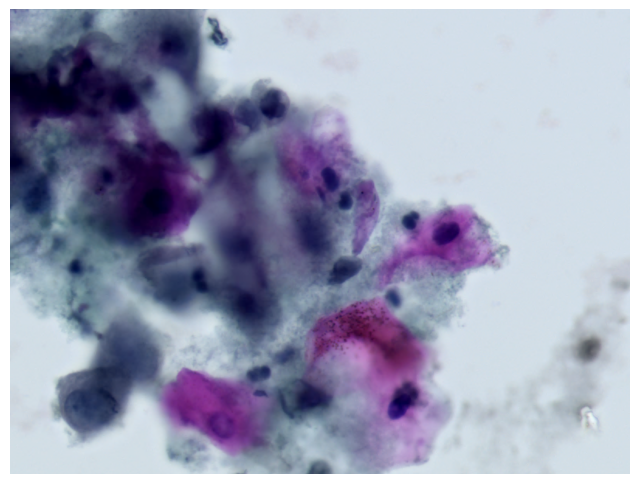

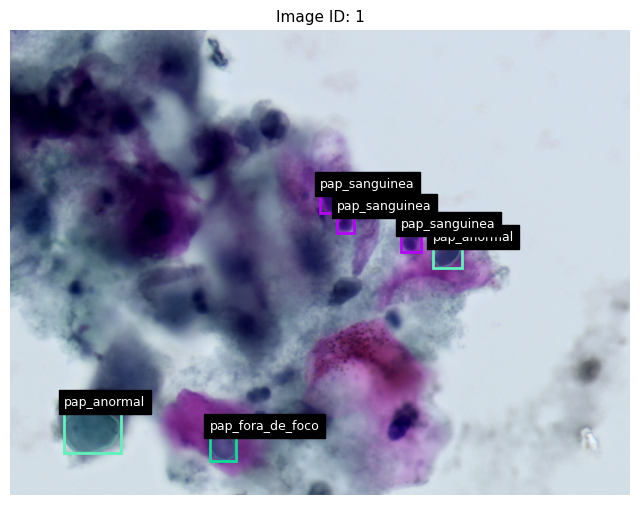

In [22]:
plot_image_overlayed(
    images_path,
    TEST_DATASET_JSON,
    max_images=1,
    plot_contours=True,
    plot_masks=True,
    figure_size=(8, 8),
    legend_font_size=9,
    alpha=0.2
)